# Twitter US Airline Sentiment ULMFiT approach

In [ ]:
!pip install fastai==2.0.10

     |████████████████████████████████| 358kB 2.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.text.all import *

## Dataset

In [ ]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 5.3MB 5.9MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 133kB 46.2MB/s 
     |████████████████████████████████| 112kB 46.3MB/s 


In [ ]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [ ]:
path = Path('twitter-sentiment')
path.mkdir(parents=True, exist_ok=True)

In [ ]:
! kaggle datasets download crowdflower/twitter-airline-sentiment -p "{path}" --unzip

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 84.0MB/s]


In [ ]:
df = pd.read_csv(path/'Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
train_df, valid_df = df.loc[:12000,:], df.loc[12000:,:]
len(train_df), len(valid_df)

(12001, 2640)

## Language model

In [ ]:
dls_lm = TextDataLoaders.from_df(df, path=path, text_col='text', is_lm=True, valid_pct=0.2)

In [ ]:
dls_lm.show_batch()

,text,text_
0,"xxbos @southwestair # fail southwest changes my flight to a different time and city and xxunk it on me . xxmaj they wo n't correct it . # furious xxbos @southwestair xxunk xxunk 4 moms , 4 xxunk , 1 day trip to xxup la . # xxunk # xxunk http : / / t.co / xxunk "" # southwestairlines xxbos @jetblue as requested , here 's selfie somewhere over the xxmaj","@southwestair # fail southwest changes my flight to a different time and city and xxunk it on me . xxmaj they wo n't correct it . # furious xxbos @southwestair xxunk xxunk 4 moms , 4 xxunk , 1 day trip to xxup la . # xxunk # xxunk http : / / t.co / xxunk "" # southwestairlines xxbos @jetblue as requested , here 's selfie somewhere over the xxmaj xxunk"
1,luggage with an infant and a 4 year old ? xxmaj then customer service never answered the phone . xxmaj i 've tried all night . xxbos @united what gate is xxunk leaving from ? xxbos @jetblue now we are waiting over an half hr for the packages . xxmaj what 's wrong with you guys ? ? http : / / t.co / xxunk xxbos @jetblue xxmaj touchdown xxup jfk !,with an infant and a 4 year old ? xxmaj then customer service never answered the phone . xxmaj i 've tried all night . xxbos @united what gate is xxunk leaving from ? xxbos @jetblue now we are waiting over an half hr for the packages . xxmaj what 's wrong with you guys ? ? http : / / t.co / xxunk xxbos @jetblue xxmaj touchdown xxup jfk ! xxmaj
2,xxunk the log . xxmaj xxunk … like in the 80s . xxbos @southwestair is my favorite airline ! i ca n't wait to book my flight to xxmaj new xxmaj orleans for my trip in xxmaj april ! ! :) :) xxbos @united xxmaj the xxmaj opal xxmaj dragon book xxmaj the xxmaj dragon ( ali ) has woven his murdering ways from the xxmaj philippines to xxmaj australia http :,the log . xxmaj xxunk … like in the 80s . xxbos @southwestair is my favorite airline ! i ca n't wait to book my flight to xxmaj new xxmaj orleans for my trip in xxmaj april ! ! :) :) xxbos @united xxmaj the xxmaj opal xxmaj dragon book xxmaj the xxmaj dragon ( ali ) has woven his murdering ways from the xxmaj philippines to xxmaj australia http : /
3,with # americanairlines # xxup aa2 xxrep 3 4 # ohio - # dallas missed my connecting flight http : / / t.co / xxunk xxbos @americanair you keep returning my call and hanging up when i answer ? xxmaj help reflight xxmaj booking xxmaj problems a flight ! xxbos 😎 xxup rt @virginamerica : xxmaj you ’ve met your match . xxmaj got status on another airline ? xxmaj upgrade (,# americanairlines # xxup aa2 xxrep 3 4 # ohio - # dallas missed my connecting flight http : / / t.co / xxunk xxbos @americanair you keep returning my call and hanging up when i answer ? xxmaj help reflight xxmaj booking xxmaj problems a flight ! xxbos 😎 xxup rt @virginamerica : xxmaj you ’ve met your match . xxmaj got status on another airline ? xxmaj upgrade ( +
4,xxmaj said i was confirmed on flight out of xxup dfw & & got here and that was only standby . xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” r u serious xxbos @united 3 hour 45 min delay so far … .. xxmaj would love to round to 4 hours to just go to bed ! xxbos @jetblue xxmaj when,said i was confirmed on flight out of xxup dfw & & got here and that was only standby . xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” r u serious xxbos @united 3 hour 45 min delay so far … .. xxmaj would love to round to 4 hours to just go to bed ! xxbos @jetblue xxmaj when i
5,"xxmaj please help . xxbos @united xxmaj aw , thanks for the kind words . xxmaj totally makes these extra 6 hours sitting in an airport s xxrep 4 o much better . xxbos @jetblue xxmaj why did you xxunk the xxmaj xxunk xxmaj series on xxunk . i do nt need to see your stupid commercials or xxmaj emergency . xxmaj info . xxbos @americanair flight xxup xxunk departing tomorrow (","please help . xxbos @united xxmaj aw , thanks for the kind words . xxmaj totally makes these extra 6 hours sitting in an airport s x

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

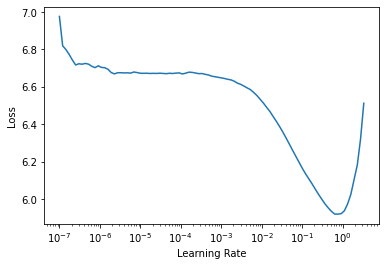

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.589088,3.973671,0.263392,53.179379,00:52


In [ ]:
learn.unfreeze()

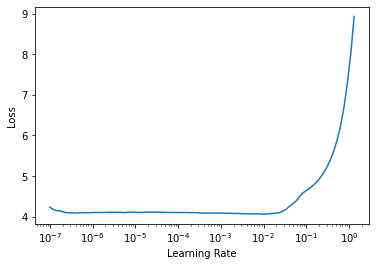

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.058833,3.903012,0.272217,49.551464,01:01
1,3.965011,3.819868,0.282525,45.598194,01:01
2,3.858835,3.757169,0.290823,42.826992,01:01
3,3.767911,3.724291,0.295131,41.441853,01:01
4,3.682255,3.694996,0.299243,40.245415,01:01
5,3.612854,3.678699,0.301364,39.594830,01:01
6,3.556318,3.675020,0.302203,39.449455,01:01
7,3.504599,3.667885,0.303353,39.168961,01:01
8,3.479185,3.667469,0.304308,39.152668,01:01
9,3.449927,3.667466,0.304454,39.152573,01:01


In [ ]:
learn.save('twitter-sentiment-lm')

Path('twitter-sentiment/models/twitter-sentiment-lm.pth')

In [ ]:
TEXT = "I liked "
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i xxunk my AA hold times when you do n't show my name . How about consistent personnel ? @southwestair i have been on hold for 3 hours waiting for my help . Thank you for the help
i xxunk Do you have any info ? i get a new license for my Late Flightr flight . Your Diego app is n't helping me . @united is the worst airline in the world …


In [ ]:
learn.save_encoder('twitter-sentiment-enc')

## Text Classifier

In [ ]:
dls_clas = TextDataLoaders.from_df(df, path=path, text_col="text", label_col="airline_sentiment", valid_pct=0.2, text_vocab=dls_lm.vocab)

In [ ]:
dls_clas.show_batch()

,text,category
0,xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - jac 29 / 9 xxup jac - lax 8 / 10 xxup lax - dub 13 / 10 . xxmaj i 'm * xxunk xxmaj what is checked bag allowance for xxup jac - lax ?,neutral
1,"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx ! xxpad xxpad xxpad xxpad xxpad",positive
2,"xxbos @southwestair i had to travel to xxmaj savannah , xxup xxunk , once again , on an airline i do n't "" luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj pl xxrep 4 e ase xxrep 4 ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",neutral
3,xxbos @usairways xxup you xxup are xxup amazing xxrep 3 ! xxup you xxup are xxup the xxup best xxrep 3 ! xxup follow xxup me xxup please xxup and i xxup follow xxup you xxup back ; ) xxrep 3 🙏 ✌ ️ 😉 ) xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,positive
4,"xxbos .@americanair ( 2 / 3 ) … i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",negative
5,"xxbos @southwestair xxmaj loved one 's flight xxup atl to xxup ind xxmaj cancelled xxmaj flightled due to "" ice in xxmaj indy "" . xxmaj sitting here in xxmaj indy , it is xxunk dry . xxmaj tomorrow 4 - 6 "" of snow . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",negative
6,"xxbos @americanair xxmaj hey , xxup aa ! xxmaj there was a mistake made by your xxup cr on my xxmaj flight xxmaj booking xxmaj problems . xxmaj when i call your reservations # , i keep getting hung up on . xxmaj advise . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",negative
7,xxbos @usairways - flight was xxmaj cancelled xxmaj flightled to xxmaj buf today . xxmaj waited in line for 2 + hrs & & xxunk service was rude . xxmaj no flight until xxmaj tues . xxmaj need to get to xxup roc . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative
8,"xxbos @usairways yes , i am as well . * * five * * xxup hours xxup on xxup hold , xxup folks . xxmaj can you xxup please tell me if this is typical ? ! xxmaj trying to be understanding here . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",negative


In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.3, metrics=accuracy)

In [ ]:
learn = learn.load_encoder('twitter-sentiment-enc')

In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.702337,0.505545,0.796790,00:29


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.579725,0.481027,0.806352,00:29


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.478611,0.465373,0.815232,00:33


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.403855,0.474239,0.815915,00:38
1,0.342837,0.474566,0.822404,00:37


In [ ]:
learn.show_results()

,text,category,category_
0,xxbos @usairways xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,negative,negative
1,"xxbos @united xxmaj hi , xxmaj i m flying xxup sfo - lax - xxunk - xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and xxunk on xxup xxunk ? xxpad xxpad",neutral,neutral
2,xxbos @united - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - sfo # xxunk . xxmaj you 're the xxup only airline w / out wifi … and pls no ' xxunk ' xxup bs . xxpad xxpad xxpad,negative,negative
3,xxbos @americanair xxmaj hi . i have xxup koa - lax - phl - ord booked as a 1-way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - lax - phx - ord would i have to pay any fees xxpad xxpad xxpad xxpad xxpad xxpad,neutral,neutral
4,xxbos @southwestair no delay . i pay $ xxrep 3 7 xxunk for xxup bs xxup a1 ticket . xxmaj you boarded flight early . xxmaj i 'm last to board . xxmaj now have middle seat . xxmaj wasted xxrep 4 $ ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative,negative
5,xxbos @united : xxmaj unhappy with xxmaj united 's service ? \n\n xxmaj read xxmaj xxunk xxmaj xxunk 's open letter to ual 's xxup ceo . \n\n xxmaj leave a comment or xxup rt . \n\n http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative,neutral
6,"xxbos @united ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm cert at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",negative,negative
7,xxbos @jetblue waiting for a flight to xxup fl for 1 / 2 marathon tmrw 4 charity . u bumped us 2a xxmaj late xxmaj flightr flight & & then xxmaj cancelled flightled xxup it . xxmaj how can you fix this ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative,negative
8,xxbos @southwestair so u xxmaj cancelled xxmaj flight our flight to xxup phx bc of xxup sdf weather but flights 2 the xxup xxunk from xxup sdf are still going on ? ! xxup wtf ? http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative,negative
